<a href="https://colab.research.google.com/github/shadeq2022/Belajar-Pengembangan-Machine-Learning/blob/main/Creating_an_NLP_Model_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Membuat Model NLP dengan TensorFlow**

# **Data diri (sesuai profil dicoding)**

Nama : Muhammad Shadeq

Email : muhammadshadeq25@gmail.com

Universitas Andalas

# **1. Import Library yang dibutuhkan**

In [170]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import nltk
import re
import string
import unicodedata

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **2. Baca, Cleaning dan Visualisasi Data**

In [171]:
#variabel data berita
df = pd.read_csv('cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [172]:
#jumlah semua data
df.shape

(47692, 2)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [174]:
#Fokus ke cyberbullying_type
df.cyberbullying_type.value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [175]:
# Check apakah data terdapat nilai Null
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

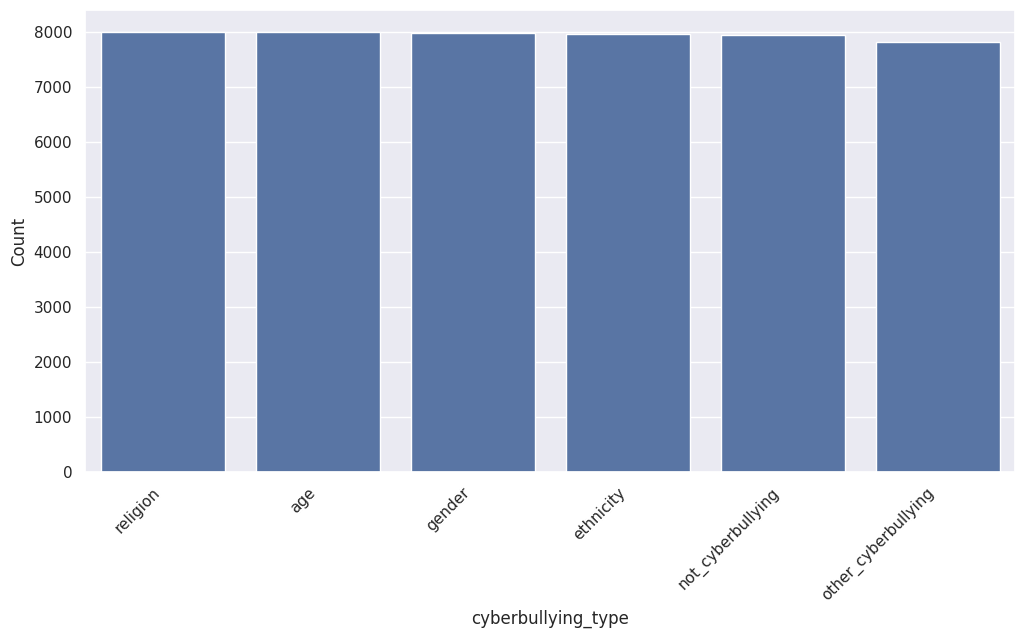

In [176]:
#Visualisasi data berdasarkan cyberbullying_type
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(x="cyberbullying_type", data=df, order=df['cyberbullying_type'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('cyberbullying_type')
plt.ylabel('Count')
plt.show()

## **3. Data Cleaning**

### **Menghilangkan Stopwords**

Dalam konteks analisis teks atau pelatihan model machine learning pada data teks, menghilangkan stopwords dapat membantu meningkatkan akurasi dan efisiensi, karena kata-kata ini tidak membawa informasi signifikan tentang konten atau topik. Contoh stopwords dalam bahasa Inggris meliputi kata-kata seperti "the", "and", "is", "of", "in", dan lainnya.

In [177]:
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

In [178]:
# data cleaning
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#hapus square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#hapus URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)
#hapus stopwords dari text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stwd:
            final_text.append(i.strip())
    return " ".join(final_text)
#hapus noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['tweet_text']=df['tweet_text'].apply(denoise_text)

<ipython-input-178-be65f0243eb5>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-178-be65f0243eb5>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### **Jumlah Word**

In [179]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.tweet_text)
corpus[:10]

['words',
 '#katandandre,',
 'food',
 'crapilicious!',
 '#mkr',
 '#aussietv',
 'white?',
 '#MKR',
 '#theblock',
 '#ImACelebrityAU']

In [180]:
#banyak kata yang sering ditemukan
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'school': 6679,
 'like': 5249,
 'high': 4644,
 'dumb': 4387,
 'bullied': 4265,
 'RT': 4188,
 'people': 3791,
 'u': 3241,
 'fuck': 3019,
 'rape': 3018}

In [181]:
def get_top_text_ngrams(corpus, n, g):
    cv = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_words = cv.transform(corpus)
    sum_words = bag_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

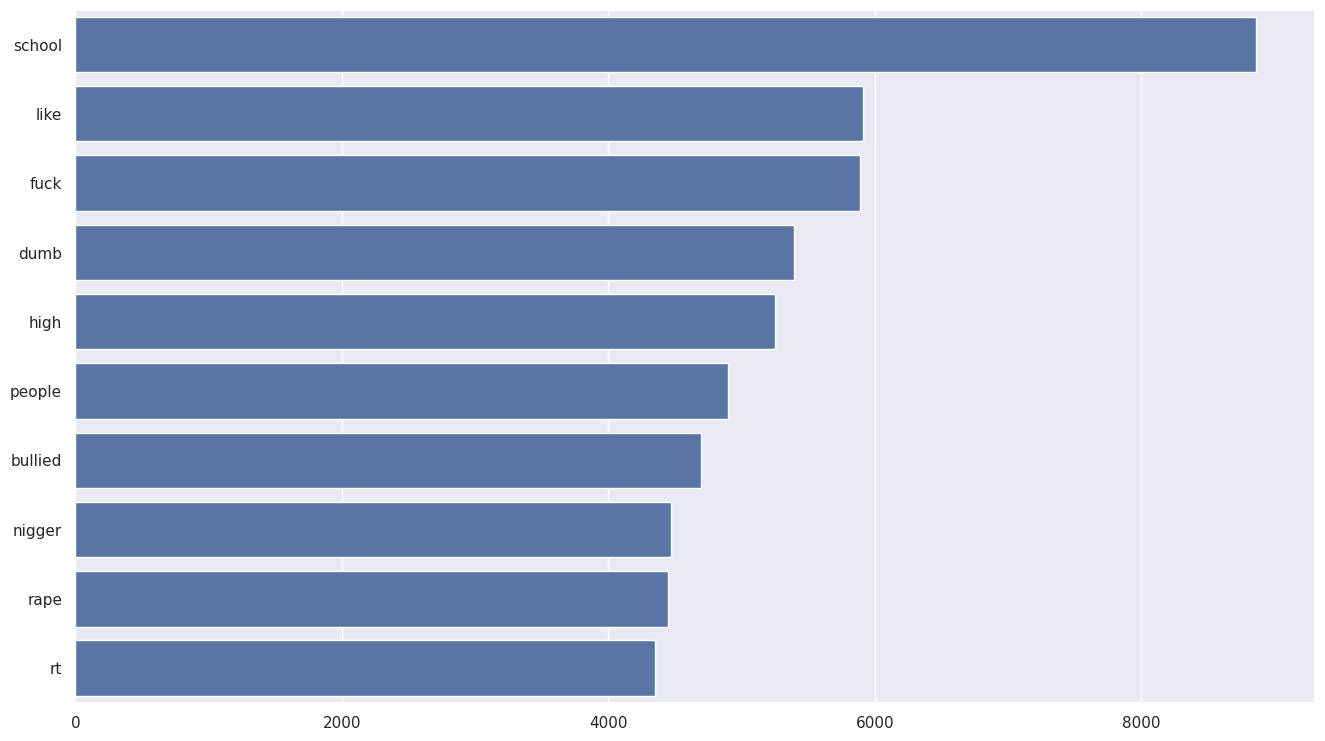

In [182]:
plt.figure(figsize = (16,9))
most_common = get_top_text_ngrams(df.tweet_text,10,1)
most_common = dict(most_common)
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))

### **Encoding & Splitting Data**

In [183]:
# data cyberbullying_type one-hot-encoding
category = pd.get_dummies(df.cyberbullying_type)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns=['cyberbullying_type'])
df_baru['tweet_text']=df_baru['tweet_text'].fillna('').apply(str)
df_baru.head(28999)

,tweet_text,age,ethnicity,gender,not_cyberbullying,other_cyberbullying,religion
0,"words #katandandre, food crapilicious! #mkr",0,0,0,1,0,0
1,#aussietv white? #MKR #theblock #ImACelebrityA...,0,0,0,1,0,0
2,@XochitlSuckkks classy whore? red velvet cupca...,0,0,0,1,0,0
3,"@Jason_Gio meh. :P thanks heads up, concerned ...",0,0,0,1,0,0
4,@RudhoeEnglish ISIS account pretending Kurdish...,0,0,0,1,0,0
...,...,...,...,...,...,...,...
28994,COINCIDENCE?,0,0,0,0,1,0
28995,Congrats literally harassing someone Twitter. ...,0,0,0,0,1,0
28996,know find people stand fire.,0,0,0,0,1,0
28997,.@JohnMcCain Blindsides GOP Shock Response:,0,0,0,0,1,0


In [184]:
# change dataframe value to numpy array
tweet = new_cat['tweet_text'].values
label = new_cat[['age', 'ethnicity', 'gender',
    'not_cyberbullying', 'other_cyberbullying',
    'religion']].values

In [185]:
# cek twett
tweet

array(['words #katandandre, food crapilicious! #mkr',
       '#aussietv white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc',
       '@XochitlSuckkks classy whore? red velvet cupcakes?', ...,
       "swear God. dumb nigger bitch. got bleach hair reeeeeal fuckin' soon. D:< FUCK.",
       'Yea fuck RT @therealexel: YOURE NIGGER FUCKING UNFOLLOW ME, FUCKING DUMB NIGGERS.',
       'Bro. U gotta chill RT @CHILLShrammy: Dog FUCK KP dumb nigger bitch lmao'],
      dtype=object)

In [186]:
#cek label
label

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

**Bagi dataset 20%  validasi test**

In [187]:
X_train,X_test,y_train,y_test = train_test_split(tweet, label,test_size = 0.2,shuffle=True)

## **4. Tokenizer dan Pemodelan Sequential dengan Embedding dan LSTM**

In [188]:
vocab_size = 5000
max_len = 100
trunc_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

print(pad_test.shape)

(9539, 100)


In [189]:
pad_train

array([[   0,    0,    0, ...,    1,   63,    1],
       [   0,    0,    0, ...,    1, 3082,    4],
       [   0,    0,    0, ...,  294,   21, 1246],
       ...,
       [   0,    0,    0, ..., 3748,  123, 1742],
       [   0,    0,    0, ..., 1587,  474,  348],
       [   0,    0,    0, ...,   48,    1,  533]], dtype=int32)

In [190]:
pad_test

array([[   0,    0,    0, ...,    3,    1,  192],
       [   0,    0,    0, ...,    0,    1,  138],
       [   0,    0,    0, ..., 1618,   25, 3551],
       ...,
       [   0,    0,    0, ...,    2,  559,   14],
       [   0,    0,    0, ...,  260, 1798, 1304],
       [   0,    0,    0, ...,    2,   14, 1387]], dtype=int32)

In [191]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 64)           320000    
                                                                 
 lstm_12 (LSTM)              (None, 128)               98816     
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 6)                 774       
                                                                 
Total params: 436102 (1.66 MB)
Trainable params: 436102 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      self.model.stop_training = True
      print("\n Akurasi dari training set dan validation set telah terpenuhi > 98%!")
callbacks = myCallback()

num_epochs = 50
history = model.fit(pad_train, y_train, epochs=num_epochs,
                    validation_data=(pad_test, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
1193/1193 - 27s - loss: 0.5866 - accuracy: 0.7557 - val_loss: 0.4082 - val_accuracy: 0.8298 - 27s/epoch - 22ms/step
Epoch 2/50
1193/1193 - 11s - loss: 0.3681 - accuracy: 0.8522 - val_loss: 0.4026 - val_accuracy: 0.8357 - 11s/epoch - 9ms/step
Epoch 3/50
1193/1193 - 12s - loss: 0.3151 - accuracy: 0.8728 - val_loss: 0.4259 - val_accuracy: 0.8329 - 12s/epoch - 10ms/step
Epoch 4/50
1193/1193 - 10s - loss: 0.2832 - accuracy: 0.8842 - val_loss: 0.4582 - val_accuracy: 0.8267 - 10s/epoch - 9ms/step
Epoch 5/50
1193/1193 - 10s - loss: 0.2570 - accuracy: 0.8943 - val_loss: 0.4603 - val_accuracy: 0.8286 - 10s/epoch - 8ms/step
Epoch 6/50
1193/1193 - 10s - loss: 0.2344 - accuracy: 0.9021 - val_loss: 0.5205 - val_accuracy: 0.8249 - 10s/epoch - 8ms/step
Epoch 7/50
1193/1193 - 10s - loss: 0.2150 - accuracy: 0.9081 - val_loss: 0.5485 - val_accuracy: 0.8257 - 10s/epoch - 8ms/step
Epoch 8/50
